In [16]:
import asyncio
import io
import glob
import os
import sys
import time
import uuid
import requests
from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw
from tqdm import tqdm
import json
from sklearn.metrics import pairwise_distances, roc_auc_score
sys.path.append("../")
from utils import prewhiten, l2_normalize
from tqdm import tqdm
import json
import tensorflow as tf
import numpy as np
from keras.preprocessing import image
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn
seaborn.set()

In [17]:
model_path = '/home/ivan/.fawkes/high_extract.h5'
model = tf.keras.models.load_model(model_path)

In [50]:
class PersonImages:
    def __init__(self, person_name):
        self.clean_folder = ""
        self.clean_images = []
        self.adversarial_images = []
        self.reloaded_adversarial_images = []
        self.orig_mean = None
        self.orig_std = None
        self.person_name = person_name
        self.adversarial_save_folder = None
    
    def _load_one_fawkes(self, path):
        img = Image.open(path).convert("RGB").resize((224, 224))
#         img_arr = image.img_to_array(img)
        img_arr = np.array(img).astype(np.float32)
    
        mean = [103.939, 116.779, 123.68]
        tanh_constant = 2 - 1e-6
        
#         img_arr = img_arr[..., ::-1]- mean
        
        img_arr /= 255.0
        img_arr -= 0.5
        img_arr *= tanh_constant
        tanh_imgs = np.arctanh(img_arr)
        
        return tanh_imgs
        
        
    def _load_folder_for_fawkes(self, folder):
        paths_list = glob.glob(os.path.join(folder, "*"))
        
        final_imgs = []
        for img_path in paths_list:
                
            final_imgs.append(self._load_one_fawkes(img_path))
        
        final_imgs = np.array(final_imgs)
        mean, std = np.mean(final_imgs), np.std(final_imgs)
        return final_imgs, mean, std        
        
    def load_clean_from_folder(self, clean_folder):
        self.clean_folder = clean_folder
        self.clean_images, self.orig_mean, self.orig_std = self._load_folder_for_fawkes(clean_folder)
    
    def _load_plain(self, folder):
        imgs, mean, std = self._load_folder_for_fawkes(folder, crop=False, resize_size=None)
        return imgs
        
    def reload_adversarial(self):
        self.reloaded_adversarial_images = self._load_plain(self.adversarial_save_folder)
        
    def _undo_preprocess(self, images):
        restored_images = images.copy()
#         restored_images  *= self.orig_std
#         restored_images += self.orig_mean
        restored_images = np.clip(restored_images, 0.0, 255.0)
        return np.uint8(restored_images)
    
    def get_clean_for_display(self):
        return self._undo_preprocess(self.clean_images)
    
    def get_adversarial_for_display(self):
        return self._undo_preprocess(self.adversarial_images)
    
    def save_adversarial(self, save_path, save_format):
        self.adversarial_save_folder = save_path
        self.adversarial_save_format = save_format
        adversarial_for_save = self.get_adversarial_for_display()
        
        for indx, img in enumerate(adversarial_for_save):
            Image.fromarray(img).save(
                os.path.join(save_path, f"{self.person_name}_{indx:02d}.{self.adversarial_save_format}")
            )
            
    def _compute_embeddings(self, model, images):
        return model.predict(np.array(images), batch_size=len(images))
    
    def compute_clean_embeddings_with_model(self, model):
        self.clean_embeddings = self._compute_embeddings(model, self.clean_images)
        
    def compute_adversarial_embeddings_with_model(self, model):
        self.adversarial_embeddings = self._compute_embeddings(model, self.adversarial_images)
        
    def compute_reloaded_adversarial_embeddings_with_model(self, model):
        self.reloaded_adversarial_embeddings = self._compute_embeddings(model, self.reloaded_adversarial_images)

In [51]:
def clean_folder_path(name):
    if name != "n000958":
        return f"/data/vggface/test_perturbed_sampled/{name}/community_naive_mean/n000958/epsilon_0.0/png"
    else:
        return f"/data/vggface/test_perturbed_sampled/{name}/community_naive_mean/n000029/epsilon_0.0/png"

In [52]:
person_a = PersonImages("n000029")
person_a.load_clean_from_folder(clean_folder_path(person_a.person_name))
person_a.compute_clean_embeddings_with_model(model)

In [53]:
person_b = PersonImages("n000958")
person_b.load_clean_from_folder(clean_folder_path(person_b.person_name))
person_b.compute_clean_embeddings_with_model(model)

In [54]:
def roc_curve(positive, negative):
    ground_truth = [0 for x in positive] + [5 for x in negative]
    scores = np.concatenate((positive, negative), axis=0)

    roc_auc = roc_auc_score(
        y_true=ground_truth,
        y_score=scores, 
    )
    print(f"Computed ROC AUC: {roc_auc:.3f}")
    
    thresholds = np.arange(1e-6, 2.0, 0.1)
    tprs = []
    fprs = []
    n_pos = float(len(positive))
    n_neg = float(len(negative))

    print("**** Computing ROC curve *****")
    for t in thresholds:
        tp = np.sum(positive < t)
        fp = np.sum(negative < t)
        tprs.append(tp / n_pos)
        fprs.append(fp / n_neg)

    plt.plot(np.arange(0.0, 1.1, 0.1), np.arange(0.0, 1.1, 0.1), label="y=x")
    plt.plot(fprs, tprs, label="Fawkes network")
    plt.legend()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.title("ROC Curve for model")

In [55]:
def sanity_check(model, person_a, person_b):    
    self_distances = pairwise_distances(
         l2_normalize(person_a.clean_embeddings),
         l2_normalize(person_a.clean_embeddings),
         metric='euclidean',
         n_jobs=4
    )
    # all distances below the diagonal compare every pair and exclude 0's to self
    self_dist_indices = np.tril_indices(n=len(person_a.clean_embeddings), k=-1)
    
    # this selection returns a flattened array of distances that are ground truth True
    self_distances = self_distances[self_dist_indices]

    negative_distances = pairwise_distances(
        l2_normalize(person_a.clean_embeddings),
        l2_normalize(person_b.clean_embeddings),
        metric='euclidean',
        n_jobs=4
    ).flatten()

    roc_curve(self_distances, negative_distances)
    
    fig1, ax1 = plt.subplots()
    ax1.boxplot([self_distances, negative_distances])

Computed ROC AUC: 0.543
**** Computing ROC curve *****


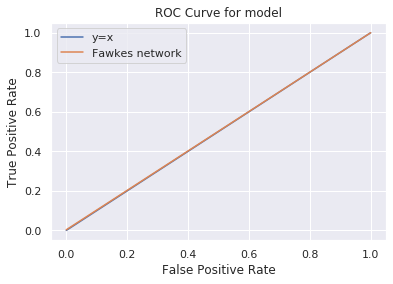

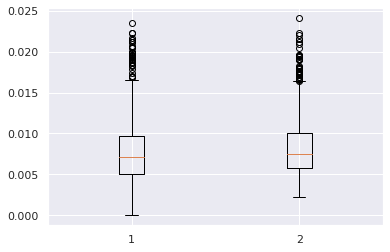

In [56]:
sanity_check(model, person_a, person_b)

## Measuring Recall

In [32]:
class FacesDatabase:
    def __init__(self, model, image_directory, attack_strategy, epsilon):
        self.model = model
        self. associated_identities = []
        self.vectors = []
        for person_name in os.listdir(image_directory):
            self.add_images_for_person(image_directory, attack_strategy, person_name, epsilon)

            
    def add_folder(self, folder_path, person_name, from_indx, to_indx):
        '''
        add all images at folder_path between alphabetically sorted from_indx and to_indx
        to person of person_name in the Azure group
        '''
        # List all jpeg, jpg and png images
        # glob returns full paths
        file_paths = [fn for fn in glob.glob(
            os.path.join(folder_path, '*')
        ) if fn.endswith("png") or fn.endswith("jpg") or fn.endswith("jpeg")]

        # Restrict to the first limit instances only in alphabetical order
        file_paths = sorted(file_paths)[from_indx:to_indx]

        print(f"Adding folder {folder_path}")
        # Add to Azure instance
        for img_path in tqdm(file_paths):
            self.vectors.append(self.compute_vector(img_path))
            self.associated_identities.append(person_name)

            
    def compute_vector(self, img_path):
        img = load_one_facenet(img_path)
        return np.array(l2_normalize(self.model(np.expand_dims(img, axis=0)))[0])
        
        
    def add_images_for_person(
            self, image_directory, attack_strategy, person_name, epsilon):
        # Get all the protected identities.
        # Remember our folder structure is ground_truth_identity/attack_strategy/protected_identity/epsilon_X/png/*.png
        folders_wildcard = os.path.join(image_directory, person_name, attack_strategy, "*")
        protected_folders = glob.glob(folders_wildcard)

        if len(protected_folders) < 1:
            print(f"For folder {folders_wildcard} no protected folders")
            return

        # 1. Add clean images truly belonging to this identity
        # When epsilon = 0.0, we have clean images and it doesn't matter which identity is "being protected"
        # as they are all unmodified images but duplicated in each identity.
        clean_folder = os.path.join(protected_folders[0], "epsilon_0.0", "png")

        # For now, hard code that we take only 1  clean image - the first one alphabetically.
        self.add_folder(clean_folder, person_name, 0, 1)

        # 2. Add decoy images belonging to this person_name in reality but modified to protect protected identities
        # For each identity, get one decoy at a different index.
        for indx, protected_identity_folder in enumerate(protected_folders):
            full_folder_path = os.path.join(
                protected_identity_folder, f"epsilon_{epsilon}", "png")
            self.add_folder(full_folder_path, person_name, indx + 1, indx + 2)

    
    def nearest_neighbor_to_img_at_path(self, query_path):
        query_vector = self.compute_vector(query_path)
        distances = pairwise_distances([query_vector], self.vectors)[0]
        return self.associated_identities[np.argmin(distances)]
        

In [36]:
def measure_local_recall(
    face_database,
    image_directory,
):
    discovery = []
    true = []
    identified_as = []

    for protector in os.listdir(image_directory):
        # We are sourcing query photos from epsilon_0.0.
        # In those cases, all subfolders in the "protected" identity have the same, clean
        # photo of the protector, so we just pick any single one that exists (e.g. n000958)
        # For the case where n000958 is itself the protector, n000958 is not present in its protected
        # subfolders, so we pick n000029 without loss of generality.
        if protector == "n000958":
            protected = "n000029"
        else:
            protected = "n000958"

        query_photos_paths = sorted(glob.glob(
            f"{image_directory}/{protector}/community_naive_mean/{protected}/epsilon_0.0/png/*"
        ))

    
        top_identity = faces_database.nearest_neighbor_to_img_at_path(query_photos_paths[11])
        true.append(protector)
        identified_as.append(top_identity)


        if top_identity == protector:
            discovery.append(1.0)
        else:
            discovery.append(0.0)

    
    for true_id, recognized_id in zip(true, identified_as):
        print(f"Face of {true_id} identitifed as {recognized_id}")
        
    return sum(discovery)/len(discovery)

In [34]:
faces_database = FacesDatabase(model, "/data/vggface/test_perturbed_sampled", "robust_community_naive_mean", 0.5)


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n001781/robust_community_naive_mean/n009232/epsilon_0.0/png
Adding folder /data/vggface/test_perturbed_sampled/n001781/robust_community_naive_mean/n009232/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001781/robust_community_naive_mean/n000958/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n001781/robust_community_naive_mean/n003356/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001781/robust_community_naive_mean/n008655/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001781/robust_community_naive_mean/n008613/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n001781/robust_community_naive_mean/n004658/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001781/robust_community_naive_mean/n001683/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001781/robust_community_naive_mean/n002647/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n001781/robust_community_naive_mean/n009288/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001781/robust_community_naive_mean/n005427/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001781/robust_community_naive_mean/n002763/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n001781/robust_community_naive_mean/n002503/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001781/robust_community_naive_mean/n003215/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001781/robust_community_naive_mean/n005359/epsilon_0.5/png


100%|██████████| 1/1 [00:00<00:00, 12.12it/s]
0it [00:00, ?it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n001781/robust_community_naive_mean/n005303/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001781/robust_community_naive_mean/decoys_epsilon_0.5.h5/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001781/robust_community_naive_mean/n007548/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001781/robust_community_naive_mean/n000029/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n001781/robust_community_naive_mean/n009114/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009232/robust_community_naive_mean/n001781/epsilon_0.0/png
Adding folder /data/vggface/test_perturbed_sampled/n009232/robust_community_naive_mean/n001781/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n009232/robust_community_naive_mean/n000958/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009232/robust_community_naive_mean/n003356/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009232/robust_community_naive_mean/n008655/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n009232/robust_community_naive_mean/n008613/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009232/robust_community_naive_mean/n004658/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009232/robust_community_naive_mean/n001683/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n009232/robust_community_naive_mean/n002647/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009232/robust_community_naive_mean/n009288/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009232/robust_community_naive_mean/n005427/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n009232/robust_community_naive_mean/n002763/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009232/robust_community_naive_mean/n002503/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009232/robust_community_naive_mean/n003215/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n009232/robust_community_naive_mean/n005359/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009232/robust_community_naive_mean/n005303/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009232/robust_community_naive_mean/n007548/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n009232/robust_community_naive_mean/n000029/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009232/robust_community_naive_mean/n009114/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000958/robust_community_naive_mean/n001781/epsilon_0.0/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n000958/robust_community_naive_mean/n001781/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000958/robust_community_naive_mean/n009232/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000958/robust_community_naive_mean/n003356/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n000958/robust_community_naive_mean/n008655/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000958/robust_community_naive_mean/n008613/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000958/robust_community_naive_mean/n004658/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n000958/robust_community_naive_mean/n001683/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000958/robust_community_naive_mean/n002647/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000958/robust_community_naive_mean/n009288/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n000958/robust_community_naive_mean/n005427/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000958/robust_community_naive_mean/n002763/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000958/robust_community_naive_mean/n002503/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n000958/robust_community_naive_mean/n003215/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000958/robust_community_naive_mean/n005359/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000958/robust_community_naive_mean/n005303/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n000958/robust_community_naive_mean/n007548/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000958/robust_community_naive_mean/n000029/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000958/robust_community_naive_mean/n009114/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n003356/robust_community_naive_mean/n001781/epsilon_0.0/png
Adding folder /data/vggface/test_perturbed_sampled/n003356/robust_community_naive_mean/n001781/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003356/robust_community_naive_mean/n009232/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n003356/robust_community_naive_mean/n000958/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003356/robust_community_naive_mean/n008655/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003356/robust_community_naive_mean/n008613/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n003356/robust_community_naive_mean/n004658/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003356/robust_community_naive_mean/n001683/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003356/robust_community_naive_mean/n002647/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n003356/robust_community_naive_mean/n009288/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003356/robust_community_naive_mean/n005427/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003356/robust_community_naive_mean/n002763/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n003356/robust_community_naive_mean/n002503/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003356/robust_community_naive_mean/n003215/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003356/robust_community_naive_mean/n005359/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n003356/robust_community_naive_mean/n005303/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003356/robust_community_naive_mean/n007548/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003356/robust_community_naive_mean/n000029/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n003356/robust_community_naive_mean/n009114/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008655/robust_community_naive_mean/n001781/epsilon_0.0/png
Adding folder /data/vggface/test_perturbed_sampled/n008655/robust_community_naive_mean/n001781/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n008655/robust_community_naive_mean/n009232/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008655/robust_community_naive_mean/n000958/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008655/robust_community_naive_mean/n003356/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n008655/robust_community_naive_mean/n008613/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008655/robust_community_naive_mean/n004658/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008655/robust_community_naive_mean/n001683/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n008655/robust_community_naive_mean/n002647/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008655/robust_community_naive_mean/n009288/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008655/robust_community_naive_mean/n005427/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n008655/robust_community_naive_mean/n002763/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008655/robust_community_naive_mean/n002503/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008655/robust_community_naive_mean/n003215/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n008655/robust_community_naive_mean/n005359/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008655/robust_community_naive_mean/n005303/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008655/robust_community_naive_mean/n007548/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n008655/robust_community_naive_mean/n000029/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008655/robust_community_naive_mean/n009114/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008613/robust_community_naive_mean/n001781/epsilon_0.0/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n008613/robust_community_naive_mean/n001781/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008613/robust_community_naive_mean/n009232/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008613/robust_community_naive_mean/n000958/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n008613/robust_community_naive_mean/n003356/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008613/robust_community_naive_mean/n008655/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008613/robust_community_naive_mean/n004658/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n008613/robust_community_naive_mean/n001683/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008613/robust_community_naive_mean/n002647/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008613/robust_community_naive_mean/n009288/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n008613/robust_community_naive_mean/n005427/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008613/robust_community_naive_mean/n002763/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008613/robust_community_naive_mean/n002503/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n008613/robust_community_naive_mean/n003215/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008613/robust_community_naive_mean/n005359/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008613/robust_community_naive_mean/n005303/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n008613/robust_community_naive_mean/n007548/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008613/robust_community_naive_mean/n000029/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n008613/robust_community_naive_mean/n009114/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n004658/robust_community_naive_mean/n001781/epsilon_0.0/png
Adding folder /data/vggface/test_perturbed_sampled/n004658/robust_community_naive_mean/n001781/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n004658/robust_community_naive_mean/n009232/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n004658/robust_community_naive_mean/n000958/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n004658/robust_community_naive_mean/n003356/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n004658/robust_community_naive_mean/n008655/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n004658/robust_community_naive_mean/n008613/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n004658/robust_community_naive_mean/n001683/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n004658/robust_community_naive_mean/n002647/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n004658/robust_community_naive_mean/n009288/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n004658/robust_community_naive_mean/n005427/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n004658/robust_community_naive_mean/n002763/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n004658/robust_community_naive_mean/n002503/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n004658/robust_community_naive_mean/n003215/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n004658/robust_community_naive_mean/n005359/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n004658/robust_community_naive_mean/n005303/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n004658/robust_community_naive_mean/n007548/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n004658/robust_community_naive_mean/n000029/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n004658/robust_community_naive_mean/n009114/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001683/robust_community_naive_mean/n001781/epsilon_0.0/png
Adding folder /data/vggface/test_perturbed_sampled/n001683/robust_community_naive_mean/n001781/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n001683/robust_community_naive_mean/n009232/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001683/robust_community_naive_mean/n000958/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001683/robust_community_naive_mean/n003356/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n001683/robust_community_naive_mean/n008655/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001683/robust_community_naive_mean/n008613/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001683/robust_community_naive_mean/n004658/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n001683/robust_community_naive_mean/n002647/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001683/robust_community_naive_mean/n009288/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001683/robust_community_naive_mean/n005427/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n001683/robust_community_naive_mean/n002763/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001683/robust_community_naive_mean/n002503/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001683/robust_community_naive_mean/n003215/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n001683/robust_community_naive_mean/n005359/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001683/robust_community_naive_mean/n005303/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001683/robust_community_naive_mean/n007548/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n001683/robust_community_naive_mean/n000029/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n001683/robust_community_naive_mean/n009114/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002647/robust_community_naive_mean/n001781/epsilon_0.0/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n002647/robust_community_naive_mean/n001781/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002647/robust_community_naive_mean/n009232/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n002647/robust_community_naive_mean/n000958/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002647/robust_community_naive_mean/n003356/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002647/robust_community_naive_mean/n008655/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n002647/robust_community_naive_mean/n008613/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002647/robust_community_naive_mean/n004658/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002647/robust_community_naive_mean/n001683/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n002647/robust_community_naive_mean/n009288/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002647/robust_community_naive_mean/n005427/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002647/robust_community_naive_mean/n002763/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n002647/robust_community_naive_mean/n002503/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002647/robust_community_naive_mean/n003215/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002647/robust_community_naive_mean/n005359/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n002647/robust_community_naive_mean/n005303/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002647/robust_community_naive_mean/n007548/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002647/robust_community_naive_mean/n000029/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n002647/robust_community_naive_mean/n009114/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009288/robust_community_naive_mean/n001781/epsilon_0.0/png
Adding folder /data/vggface/test_perturbed_sampled/n009288/robust_community_naive_mean/n001781/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n009288/robust_community_naive_mean/n009232/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009288/robust_community_naive_mean/n000958/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009288/robust_community_naive_mean/n003356/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n009288/robust_community_naive_mean/n008655/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009288/robust_community_naive_mean/n008613/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009288/robust_community_naive_mean/n004658/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n009288/robust_community_naive_mean/n001683/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009288/robust_community_naive_mean/n002647/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009288/robust_community_naive_mean/n005427/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n009288/robust_community_naive_mean/n002763/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009288/robust_community_naive_mean/n002503/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009288/robust_community_naive_mean/n003215/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n009288/robust_community_naive_mean/n005359/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009288/robust_community_naive_mean/n005303/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009288/robust_community_naive_mean/n007548/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n009288/robust_community_naive_mean/n000029/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009288/robust_community_naive_mean/n009114/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005427/robust_community_naive_mean/n001781/epsilon_0.0/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n005427/robust_community_naive_mean/n001781/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005427/robust_community_naive_mean/n009232/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005427/robust_community_naive_mean/n000958/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n005427/robust_community_naive_mean/n003356/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005427/robust_community_naive_mean/n008655/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005427/robust_community_naive_mean/n008613/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n005427/robust_community_naive_mean/n004658/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005427/robust_community_naive_mean/n001683/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005427/robust_community_naive_mean/n002647/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n005427/robust_community_naive_mean/n009288/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005427/robust_community_naive_mean/n002763/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005427/robust_community_naive_mean/n002503/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n005427/robust_community_naive_mean/n003215/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005427/robust_community_naive_mean/n005359/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005427/robust_community_naive_mean/n005303/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n005427/robust_community_naive_mean/n007548/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005427/robust_community_naive_mean/n000029/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005427/robust_community_naive_mean/n009114/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n002763/robust_community_naive_mean/n001781/epsilon_0.0/png
Adding folder /data/vggface/test_perturbed_sampled/n002763/robust_community_naive_mean/n001781/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002763/robust_community_naive_mean/n009232/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n002763/robust_community_naive_mean/n000958/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002763/robust_community_naive_mean/n003356/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002763/robust_community_naive_mean/n008655/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n002763/robust_community_naive_mean/n008613/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002763/robust_community_naive_mean/n004658/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002763/robust_community_naive_mean/n001683/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n002763/robust_community_naive_mean/n002647/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002763/robust_community_naive_mean/n009288/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002763/robust_community_naive_mean/n005427/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n002763/robust_community_naive_mean/n002503/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002763/robust_community_naive_mean/n003215/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002763/robust_community_naive_mean/n005359/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n002763/robust_community_naive_mean/n005303/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002763/robust_community_naive_mean/n007548/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002763/robust_community_naive_mean/n000029/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n002763/robust_community_naive_mean/n009114/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002503/robust_community_naive_mean/n001781/epsilon_0.0/png
Adding folder /data/vggface/test_perturbed_sampled/n002503/robust_community_naive_mean/n001781/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n002503/robust_community_naive_mean/n009232/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002503/robust_community_naive_mean/n000958/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002503/robust_community_naive_mean/n003356/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n002503/robust_community_naive_mean/n008655/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002503/robust_community_naive_mean/n008613/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002503/robust_community_naive_mean/n004658/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n002503/robust_community_naive_mean/n001683/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002503/robust_community_naive_mean/n002647/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002503/robust_community_naive_mean/n009288/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n002503/robust_community_naive_mean/n005427/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002503/robust_community_naive_mean/n002763/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002503/robust_community_naive_mean/n003215/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n002503/robust_community_naive_mean/n005359/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002503/robust_community_naive_mean/n005303/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002503/robust_community_naive_mean/n007548/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n002503/robust_community_naive_mean/n000029/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n002503/robust_community_naive_mean/n009114/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003215/robust_community_naive_mean/n001781/epsilon_0.0/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n003215/robust_community_naive_mean/n001781/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003215/robust_community_naive_mean/n009232/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003215/robust_community_naive_mean/n000958/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n003215/robust_community_naive_mean/n003356/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003215/robust_community_naive_mean/n008655/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003215/robust_community_naive_mean/n008613/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n003215/robust_community_naive_mean/n004658/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003215/robust_community_naive_mean/n001683/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003215/robust_community_naive_mean/n002647/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n003215/robust_community_naive_mean/n009288/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003215/robust_community_naive_mean/n005427/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003215/robust_community_naive_mean/n002763/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n003215/robust_community_naive_mean/n002503/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003215/robust_community_naive_mean/n005359/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003215/robust_community_naive_mean/n005303/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n003215/robust_community_naive_mean/n007548/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003215/robust_community_naive_mean/n000029/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n003215/robust_community_naive_mean/n009114/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n005359/robust_community_naive_mean/n001781/epsilon_0.0/png
Adding folder /data/vggface/test_perturbed_sampled/n005359/robust_community_naive_mean/n001781/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005359/robust_community_naive_mean/n009232/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n005359/robust_community_naive_mean/n000958/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005359/robust_community_naive_mean/n003356/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005359/robust_community_naive_mean/n008655/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n005359/robust_community_naive_mean/n008613/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005359/robust_community_naive_mean/n004658/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005359/robust_community_naive_mean/n001683/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n005359/robust_community_naive_mean/n002647/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005359/robust_community_naive_mean/n009288/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005359/robust_community_naive_mean/n005427/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n005359/robust_community_naive_mean/n002763/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005359/robust_community_naive_mean/n002503/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005359/robust_community_naive_mean/n003215/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n005359/robust_community_naive_mean/n005303/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005359/robust_community_naive_mean/n007548/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005359/robust_community_naive_mean/n000029/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n005359/robust_community_naive_mean/n009114/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005303/robust_community_naive_mean/n001781/epsilon_0.0/png
Adding folder /data/vggface/test_perturbed_sampled/n005303/robust_community_naive_mean/n001781/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n005303/robust_community_naive_mean/n009232/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005303/robust_community_naive_mean/n000958/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005303/robust_community_naive_mean/n003356/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n005303/robust_community_naive_mean/n008655/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005303/robust_community_naive_mean/n008613/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005303/robust_community_naive_mean/n004658/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n005303/robust_community_naive_mean/n001683/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005303/robust_community_naive_mean/n002647/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005303/robust_community_naive_mean/n009288/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n005303/robust_community_naive_mean/n005427/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005303/robust_community_naive_mean/n002763/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005303/robust_community_naive_mean/n002503/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n005303/robust_community_naive_mean/n003215/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005303/robust_community_naive_mean/n005359/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005303/robust_community_naive_mean/n007548/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n005303/robust_community_naive_mean/n000029/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n005303/robust_community_naive_mean/n009114/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n007548/robust_community_naive_mean/n001781/epsilon_0.0/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n007548/robust_community_naive_mean/n001781/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n007548/robust_community_naive_mean/n009232/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n007548/robust_community_naive_mean/n000958/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n007548/robust_community_naive_mean/n003356/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n007548/robust_community_naive_mean/n008655/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n007548/robust_community_naive_mean/n008613/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n007548/robust_community_naive_mean/n004658/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n007548/robust_community_naive_mean/n001683/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n007548/robust_community_naive_mean/n002647/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n007548/robust_community_naive_mean/n009288/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n007548/robust_community_naive_mean/n005427/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n007548/robust_community_naive_mean/n002763/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n007548/robust_community_naive_mean/n002503/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n007548/robust_community_naive_mean/n003215/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n007548/robust_community_naive_mean/n005359/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n007548/robust_community_naive_mean/n005303/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n007548/robust_community_naive_mean/n000029/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n007548/robust_community_naive_mean/n009114/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n000029/robust_community_naive_mean/n001781/epsilon_0.0/png
Adding folder /data/vggface/test_perturbed_sampled/n000029/robust_community_naive_mean/n001781/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000029/robust_community_naive_mean/n009232/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n000029/robust_community_naive_mean/n000958/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000029/robust_community_naive_mean/n003356/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000029/robust_community_naive_mean/n008655/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n000029/robust_community_naive_mean/n008613/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000029/robust_community_naive_mean/n004658/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000029/robust_community_naive_mean/n001683/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n000029/robust_community_naive_mean/n002647/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000029/robust_community_naive_mean/n009288/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000029/robust_community_naive_mean/n005427/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n000029/robust_community_naive_mean/n002763/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000029/robust_community_naive_mean/n002503/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000029/robust_community_naive_mean/n003215/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n000029/robust_community_naive_mean/n005359/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000029/robust_community_naive_mean/n005303/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n000029/robust_community_naive_mean/n007548/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n000029/robust_community_naive_mean/n009114/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009114/robust_community_naive_mean/n001781/epsilon_0.0/png
Adding folder /data/vggface/test_perturbed_sampled/n009114/robust_community_naive_mean/n001781/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n009114/robust_community_naive_mean/n009232/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009114/robust_community_naive_mean/n000958/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009114/robust_community_naive_mean/n003356/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n009114/robust_community_naive_mean/n008655/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009114/robust_community_naive_mean/n008613/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009114/robust_community_naive_mean/n004658/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n009114/robust_community_naive_mean/n001683/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009114/robust_community_naive_mean/n002647/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009114/robust_community_naive_mean/n009288/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n009114/robust_community_naive_mean/n005427/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009114/robust_community_naive_mean/n002763/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009114/robust_community_naive_mean/n002503/epsilon_0.5/png


  0%|          | 0/1 [00:00<?, ?it/s]

Adding folder /data/vggface/test_perturbed_sampled/n009114/robust_community_naive_mean/n003215/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009114/robust_community_naive_mean/n005359/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009114/robust_community_naive_mean/n005303/epsilon_0.5/png


100%|██████████| 1/1 [00:00<00:00, 12.07it/s]

Adding folder /data/vggface/test_perturbed_sampled/n009114/robust_community_naive_mean/n007548/epsilon_0.5/png
Adding folder /data/vggface/test_perturbed_sampled/n009114/robust_community_naive_mean/n000029/epsilon_0.5/png


In [37]:
measure_local_recall(
    faces_database,
    "/data/vggface/test_perturbed_sampled",
)

Face of n001781 identitifed as n004658
Face of n009232 identitifed as n005359
Face of n000958 identitifed as n002647
Face of n003356 identitifed as n009114
Face of n008655 identitifed as n005427
Face of n008613 identitifed as n009232
Face of n004658 identitifed as n002503
Face of n001683 identitifed as n001683
Face of n002647 identitifed as n009114
Face of n009288 identitifed as n005359
Face of n005427 identitifed as n005359
Face of n002763 identitifed as n000029
Face of n002503 identitifed as n009288
Face of n003215 identitifed as n007548
Face of n005359 identitifed as n005359
Face of n005303 identitifed as n009232
Face of n007548 identitifed as n009232
Face of n000029 identitifed as n008613
Face of n009114 identitifed as n005303


0.10526315789473684